In [1]:
import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from tools import LightningModel, Cifar10DataModule, plot_loss_and_acc

In [2]:
L.pytorch.seed_everything(12)


d_module = Cifar10DataModule(batch_size=64, num_workers=4)
d_module.prepare_data()
d_module.setup()

Seed set to 12


Files already downloaded and verified


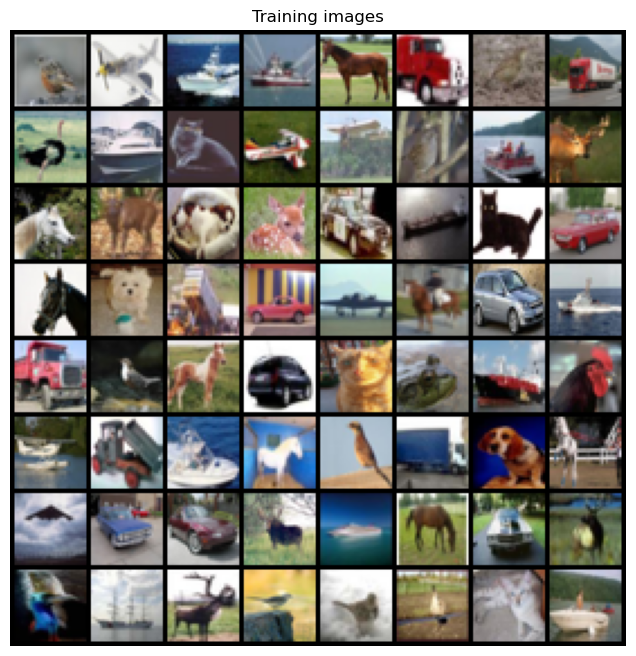

In [3]:
for images, labels in d_module.train_dataloader():
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [4]:
images[0].shape

torch.Size([3, 32, 32])

## Image augmentation

In [5]:
from torchvision import transforms

selfsupervised_transforms = transforms.Compose(
        [transforms.RandomResizedCrop(size=128),
         transforms.RandomHorizontalFlip(),
         transforms.RandomApply([transforms.ColorJitter(0.8 , 0.8, 0.8, 0.2)], p=0.8),
         transforms.RandomGrayscale(p=0.2),
         transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
         transforms.ToTensor()]
)


class AugmentedImages:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        return [self.transforms(x), self.transforms(x)]

In [6]:
L.pytorch.seed_everything(123)

dm = Cifar10DataModule(batch_size=64,
                       train_transform=AugmentedImages(selfsupervised_transforms),
                       test_transform=AugmentedImages(selfsupervised_transforms))
dm.prepare_data()
dm.setup()

Seed set to 123


Files already downloaded and verified


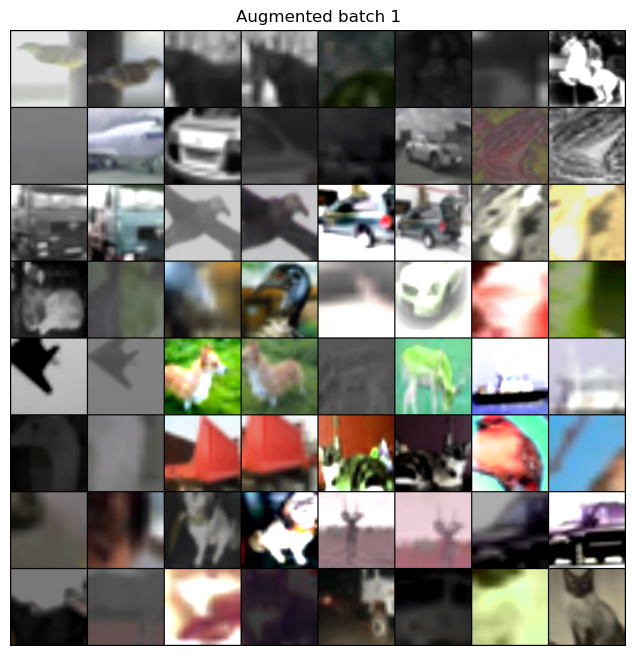

In [7]:
for images, labels in dm.train_dataloader():
    break

paired_images = []
for i in range(32):
    paired_images.append(images[0][i])
    paired_images.append(images[1][i])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Augmented batch 1")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    paired_images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

## 2 fully connected layers

In [8]:
pt_model = torch.hub.load('pytorch/vision', 'resnet18', weights=None)

pt_model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256), # embeddings, not classes!
)

Using cache found in /Users/alexandragridneva/.cache/torch/hub/pytorch_vision_main


## Info NCE loss

In [9]:
# Inspired by https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/SimCLR.ipynb

def info_nce_loss(feats, temperature, mode="train"):

    # Calculate cosine similarity
    cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)

    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)

    # Find positive example -> batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)

    # InfoNCE loss
    cos_sim = cos_sim / temperature
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()

    comb_sim = torch.cat(
        [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
        dim=-1,
    )
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    return nll, sim_argsort

In [10]:
class LightningModelSimCLR(L.LightningModule):
    def __init__(self, model, learning_rate, temperature):
        super().__init__()

        self.learning_rate = learning_rate
        self.temperature = temperature
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):

        ### NEW ###
        images, _ = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="train", temperature=self.temperature)
        self.log("train_loss", loss)
        self.log("train_acc", (sim_argsort < 5).float().mean())

        return loss

    def validation_step(self, batch, batch_idx):

        ### NEW ###
        images, _ = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="val", temperature=self.temperature)
        self.log("val_loss", loss)
        self.log("val_acc", (sim_argsort < 5).float().mean())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [11]:
L.seed_everything(12)

dm = Cifar10DataModule(batch_size=256,
                       train_transform=AugmentedImages(selfsupervised_transforms),
                       test_transform=AugmentedImages(selfsupervised_transforms))

lightning_model = LightningModelSimCLR(model=pt_model, temperature=0.07, learning_rate=0.0005)

trainer = L.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Seed set to 12
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)

Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.6 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.282    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/alexandragridneva/ProgrammingTools/miniconda3/envs/dl_lightning_ai_course_v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/alexandragridneva/ProgrammingTools/miniconda3/envs/dl_lightning_ai_course_v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import pandas as pd

def plot_loss_and_acc(
    log_dir, loss_ylim=(0.0, 0.9), acc_ylim=(0.7, 1.0), save_loss=None, save_acc=None
):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )

    #plt.ylim(loss_ylim)
    if save_loss is not None:
        plt.savefig(save_loss)

    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

    #plt.ylim(acc_ylim)
    if save_acc is not None:
        plt.savefig(save_acc)


plot_loss_and_acc(trainer.logger.log_dir)

In [ ]:
torch.save(pt_model.state_dict(), "simclr-resnet18.pt")

## Use saved model for fine-tuning

In [ ]:
pytorch_model = torch.hub.load('pytorch/vision', 'resnet18', weights=None)

pytorch_model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256), # embeddings, not classes!
)

pytorch_model.load_state_dict(torch.load('simclr-resnet18.pt'))
pytorch_model.fc = torch.nn.Linear(512, 10)

In [ ]:
L.seed_everything(12)
dm = Cifar10DataModule(height_width=(128, 128), batch_size=64, num_workers=4)

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)

In [ ]:
plot_loss_and_acc(trainer.logger.log_dir)

In [ ]:
trainer.test(model=lightning_model, datamodule=dm)